# Exercise: Feature selection - imbalance price prediction

In this exercise, we will use linear regression to predict imbalance prices using features such as past prices, day-ahead prices, renewable dispatch, and others. Though, we provide a code skeleton, feel free to edit it as you like.

## 1 - Time series prediction using past prices
In this section, we will use only the past price as features to predict the next imbalance price. For instance, to predict the price at time t, we can use the last n price realisations for slots t-n, ..., t-1 as features and fit a linear regressor. 

Now, we describe the metric used. Mean squared error (MSE) is simply the mean of the sum of squared errors (duh). Sum of squared errors is what you use as a loss function to train the linear regressor.
$$
\text{MSE} = \sum_{i=1}^T \frac{ (y_i - f_i)^2}{T}
$$

R2 is a score between 0 and 1, which represents the proportion of variance explained by our trained model, defined below.
$$
\text{R}^2 = 1-\frac{\sum(y_i-f_i)^2}{\sum(y_i-\bar{y})^2},
$$
where $\bar{y}$ is mean of the observed data, and $f_i$ is our prediction. Mean absolute error (MAE) is defined below.
$$
\text{MAE} = \sum_{i=1}^T \frac{\lvert y_i - f_i \rvert}{T}
$$

### Tasks

- First, let us prepare the data from the given dataset. The dataset provides us with prices for T slots. Prepare features and targets for a look back window of size n?
- Split the dataset into training and testing sets.
- Train a linear regressor and evaluate it on the test set using rmse, and mae metrics.
- How good is the performance?

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

def get_data(N):
    # -------------------------------------------------------------------------
    # Load the dataset and preprocess it to create a supervised learning problem.
    df = pd.read_csv("imbalance_price_features_2025_06.csv", )
    T = len(df)
    data_dict = {f"t-{N+1-n}": df["Imbalance price"].values[n-1:T-N+n-1] for n in range(1, N+1)}
    data_dict["t"] = df["Imbalance price"].values[N:T]
    data_dict["Slot Id"] = df["Slot Id"].values[N:T]
    data = pd.DataFrame(columns=['Slot Id'] + [f"t-{N+1-n}" for n in range(1, N+1)] + ["t"], data=data_dict)
    return data

def train_lin_regressor(data: pd.DataFrame, drop = [], reg = 1) -> tuple:
    """
    Trains a linear regressor to predict 'Imbalance price' using all the other features in the dataset, dropping the features in the 'drop' list.
    """
    # Drop unwanted features
    X = data.drop(columns=["t"] + drop)
    y = data["t"]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, shuffle=True
    )

    # Initialize and fit model
    model = Lasso(alpha=reg)
    model.fit(X_train, y_train)

    # Build test set dataframe for evaluation
    test_df = X_test.copy()
    test_df["y_true"] = y_test

    return model, test_df

def evaluate(test_df, model) -> dict:
    """
    Evaluates the trained model on RMSE, MAE, and R² metrics.
    """
    X_test = test_df.drop(columns=["y_true"])
    y_true = test_df["y_true"].values
    y_pred = model.predict(X_test)

    metrics = {
        "rmse": root_mean_squared_error(y_true, y_pred),
        "mae": mean_absolute_error(y_true, y_pred),
        "r2": r2_score(y_true, y_pred),
    }

    return metrics

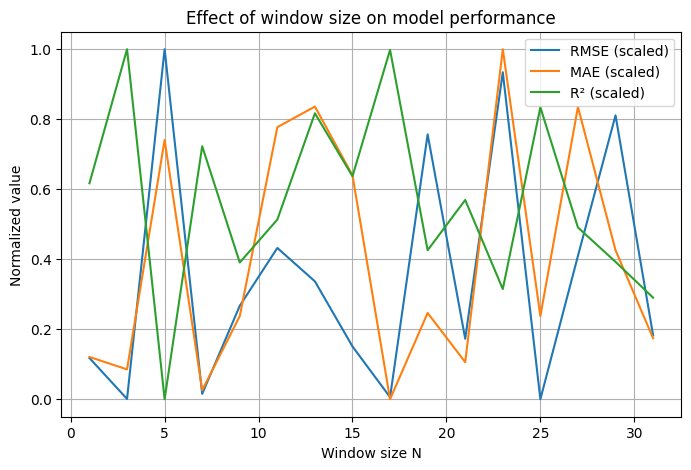

Best model: N = 3
Metrics: {'rmse': 120.195589954428, 'mae': 66.77396542181178, 'r2': 0.3078322025818563}


In [2]:
import numpy as np
import matplotlib.pyplot as plt

metrics = {'rmse': [], 'mae': [], 'r2': []}
set_N = np.linspace(1, 31, 16, dtype=int)

for N in set_N:
    data = get_data(N)
    model, test_df = train_lin_regressor(data, drop=["Slot Id"])
    m = evaluate(test_df, model)
    metrics['rmse'].append(m['rmse'])
    metrics['mae'].append(m['mae'])
    metrics['r2'].append(m['r2'])

def normalize(arr):
    arr = np.array(arr)
    return (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)

plt.figure(figsize=(8,5))
plt.plot(set_N, normalize(metrics['rmse']), label="RMSE (scaled)")
plt.plot(set_N, normalize(metrics['mae']), label="MAE (scaled)")
plt.plot(set_N, normalize(metrics['r2']), label="R² (scaled)")
plt.xlabel("Window size N")
plt.ylabel("Normalized value")
plt.title("Effect of window size on model performance")
plt.legend()
plt.grid(True)
plt.show()

best_idx = np.argmax(metrics['r2'])
best_N = set_N[best_idx]
best_metrics = {k: v[best_idx] for k,v in metrics.items()}

print(f"Best model: N = {best_N}")
print("Metrics:", best_metrics)

# 2 - Time series prediction with external features
Since, the imbalance price is affected by other market quantities, we include external features to improve our model. Note that, only features that are available a-priori to the delivery time are valid features, since prediction model needs to be run before delivery time. For instance, imbalance price depends on the system imbalance which is impacted by the share of non-controllable renewable resources like wind power. Thus, wind forecast might be a useful feature to include. Moreover, the imbalance price is also correlated with the day-ahead price. 

Domain knowledge is often the first step to search and engineer useful features.

### Tasks
- Now, use other features in the dataset as well. Try to find a nice set of features that are useful.
- What do the linear coefficients corresponding to each feature represent? Can we conclude that the smaller the coefficient, smaller is the correlation - think?
- Did you get a lot of improvement by adding new features? What is the drawback of adding more features - think computational complexity?

In [3]:
def get_data_ex_features(N):
    df = pd.read_csv("imbalance_price_features_2025_06.csv")
    data = get_data(N)
    data = data.merge(df.drop(columns=["Time slot", "Imbalance price"]), on="Slot Id")
    return data

In [6]:
data_ext = get_data_ex_features(best_N)
data_ext

,Slot Id,t-3,t-2,t-1,t,DA price,Wind,Biomass,Fossil Gas,Fossil Hard Coal,Fossil Oil,Solar,Waste
0,4,371.86,57.50,11.82,7.19,92.54,155,35.80,144.25,151.73,29.96,0.38,104.47
1,5,57.50,11.82,7.19,241.17,85.22,181,34.60,148.96,155.32,30.41,1.09,104.97
2,6,11.82,7.19,241.17,-13.31,85.22,219,34.60,148.96,155.32,30.41,1.09,104.97
3,7,7.19,241.17,-13.31,-11.21,85.22,250,34.60,148.96,155.32,30.41,1.09,104.97
4,8,241.17,-13.31,-11.21,6.11,85.22,282,34.60,148.96,155.32,30.41,1.09,104.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2872,2876,52.00,52.42,157.00,50.34,157.00,35,183.44,114.62,110.05,21.77,3.53,124.47
2873,2877,52.42,157.00,50.34,122.65,122.65,33,187.81,108.24,108.72,21.51,0.86,124.26
2874,2878,157.00,50.34,122.65,122.65,122.65,33,187.81,108.24,108.72,21.51,0.86,124.26
2875,2879,50.34,122.65,122.65,122.65,122.65,6,187.81,108.24,108.72,21.51,0.86,124.26


In [7]:
# Train model with external features
model_ext, test_df_ext = train_lin_regressor(data_ext, drop=["Slot Id"], reg=0.1)

# Evaluate performance
metrics_ext = evaluate(test_df_ext, model_ext)

print(f"Metrics with external features (N={best_N}):")
print(metrics_ext)

Metrics with external features (N=3):
{'rmse': 115.70582750321302, 'mae': 64.72916749963798, 'r2': 0.3585766160761362}


## 3 - Time series prediction with polynomial regression
Recall polynomial regression from previous exercise. Here, we want to do the same for our problem

### Tasks
- How is the performance with polynomial features? If it decreases, then why is it so?
- See if regularization helps, how can you increase regularization?
- In case of Lasso regression, observe that it results in automatic feature selection, how?

In [10]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso

def train_poly(data, drop = [], reg = 1, degree=2):
    """
    Train polynomial regression (with Lasso regularization) on the dataset.
    """
    # Separate features and target
    X = data.drop(columns=["t"] + drop)
    y = data["t"]

    # Create polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly.fit_transform(X)

    # Split train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X_poly, y, test_size=0.2, random_state=42, shuffle=True
    )

    # Train model (Lasso with regularization)
    model = Lasso(alpha=reg, max_iter=5000)
    model.fit(X_train, y_train)

    return model, X_test, y_test, poly

from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

def evaluate_poly(test_features, test_targets, model, plot=True):
    """
    Evaluate polynomial regression model on test data.
    """
    y_pred = model.predict(test_features)

    metrics = {
        "rmse": root_mean_squared_error(test_targets, y_pred),
        "mae": mean_absolute_error(test_targets, y_pred),
        "r2": r2_score(test_targets, y_pred),
    }

    if plot:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(6,4))
        plt.scatter(test_targets, y_pred, alpha=0.5)
        plt.xlabel("True imbalance price")
        plt.ylabel("Predicted imbalance price")
        plt.title("Polynomial Regression: True vs Predicted")
        plt.grid(True)
        plt.show()

    return metrics
    

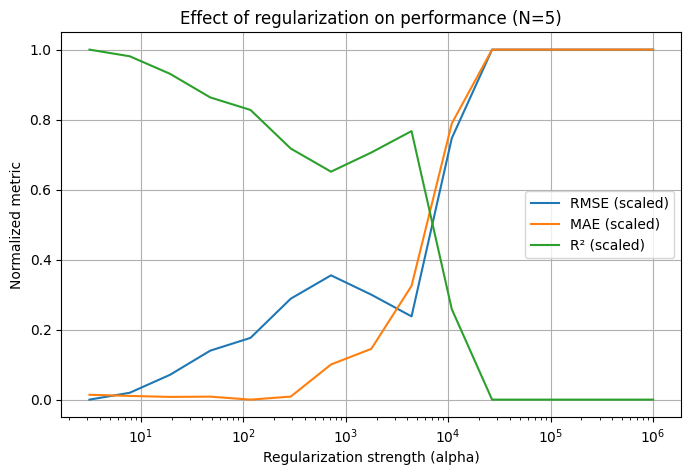

Best model: alpha = 3.1623
Metrics: {'rmse': 238.1499500255444, 'mae': 74.83399701306753, 'r2': 0.10357231076051687}


In [11]:
import numpy as np
import matplotlib.pyplot as plt

N = 5
data = get_data_ex_features(N)

metrics = {'rmse': [], 'mae': [], 'r2': []}
set_reg = np.logspace(0.5, 6, 15)  # α values

for reg in set_reg:
    model, test_df = train_lin_regressor(data, drop=["Slot Id"], reg=reg)
    m = evaluate(test_df, model)
    metrics['rmse'].append(m['rmse'])
    metrics['mae'].append(m['mae'])
    metrics['r2'].append(m['r2'])

# --- Normalize for plotting ---
def normalize(arr):
    arr = np.array(arr)
    return (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)

plt.figure(figsize=(8,5))
plt.plot(set_reg, normalize(metrics['rmse']), label="RMSE (scaled)")
plt.plot(set_reg, normalize(metrics['mae']), label="MAE (scaled)")
plt.plot(set_reg, normalize(metrics['r2']), label="R² (scaled)")
plt.xscale("log")
plt.xlabel("Regularization strength (alpha)")
plt.ylabel("Normalized metric")
plt.title(f"Effect of regularization on performance (N={N})")
plt.legend()
plt.grid(True)
plt.show()

# --- Find best model (by R²) ---
best_idx = np.argmax(metrics['r2'])
best_reg = set_reg[best_idx]
best_metrics = {k: v[best_idx] for k,v in metrics.items()}

print(f"Best model: alpha = {best_reg:.4f}")
print("Metrics:", best_metrics)

/Users/jonaswiendl/local/Repos/46765_ML4ES/ml4es_exercises/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.734e+07, tolerance: 5.603e+03
  model = cd_fast.enet_coordinate_descent(
/Users/jonaswiendl/local/Repos/46765_ML4ES/ml4es_exercises/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.711e+07, tolerance: 5.603e+03
  model = cd_fast.enet_coordinate_descent(
/Users/jonaswiendl/local/Repos/46765_ML4ES/ml4es_exercises/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to inc

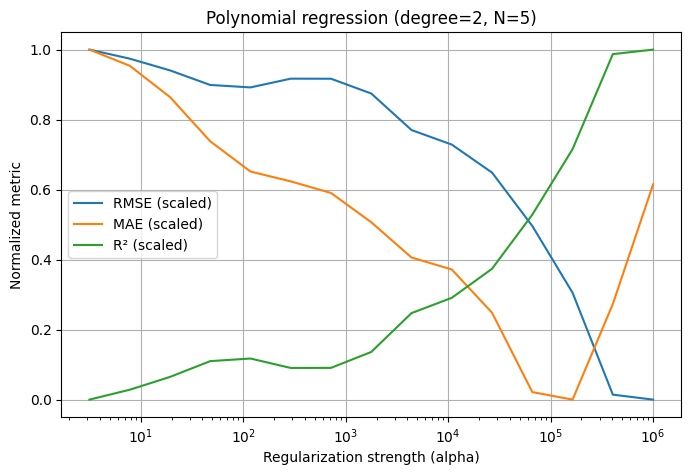

Best polynomial model: alpha = 1000000.0000
Metrics: {'rmse': 246.41121685012212, 'mae': 82.82993198896335, 'r2': 0.04030060700206628}


In [12]:
import numpy as np
import matplotlib.pyplot as plt

N = 5
data = get_data_ex_features(N)

metrics = {'rmse': [], 'mae': [], 'r2': []}
set_reg = np.logspace(0.5, 6, 15)  # α values

for reg in set_reg:
    model, X_test, y_test, poly = train_poly(data, drop=["Slot Id"], reg=reg, degree=2)
    m = evaluate_poly(X_test, y_test, model, plot=False)
    metrics['rmse'].append(m['rmse'])
    metrics['mae'].append(m['mae'])
    metrics['r2'].append(m['r2'])

# --- Normalize for plotting ---
def normalize(arr):
    arr = np.array(arr)
    return (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)

plt.figure(figsize=(8,5))
plt.plot(set_reg, normalize(metrics['rmse']), label="RMSE (scaled)")
plt.plot(set_reg, normalize(metrics['mae']), label="MAE (scaled)")
plt.plot(set_reg, normalize(metrics['r2']), label="R² (scaled)")
plt.xscale("log")
plt.xlabel("Regularization strength (alpha)")
plt.ylabel("Normalized metric")
plt.title(f"Polynomial regression (degree=2, N={N})")
plt.legend()
plt.grid(True)
plt.show()

# --- Best model (by R²) ---
best_idx = np.argmax(metrics['r2'])
best_reg = set_reg[best_idx]
best_metrics = {k: v[best_idx] for k,v in metrics.items()}

print(f"Best polynomial model: alpha = {best_reg:.4f}")
print("Metrics:", best_metrics)

## Key Insights on Polynomial Regression for Time Series

### 1. Performance with Polynomial Features
- Adding polynomial features (squared terms, interactions, etc.) **increases model complexity**.  
- In time series, most predictive power often comes from **lags and a few external drivers**, not from complex interactions.  
- Polynomial expansion can therefore **fit noise instead of signal**, which often leads to **worse generalization** (higher error, lower R²).

---

### 2. Effect of Regularization
- **Lasso regression** penalizes large coefficients, controlled by the parameter `alpha`.  
- Increasing `alpha` (stronger regularization):
  - Shrinks coefficients to prevent overfitting.  
  - Helps stabilize the model when many polynomial features are present.  
  - Too much regularization can cause **underfitting**.  
- The optimal balance is usually found by **sweeping over `alpha` values** and choosing the model with the highest R².

---

### 3. Automatic Feature Selection with Lasso
- Polynomial expansion produces a **large and redundant feature space**.  
- Lasso has the unique property of driving some coefficients **exactly to zero**.  
- This acts as **automatic feature selection**, removing irrelevant or redundant polynomial terms.  
- The result is a **sparser, simpler model** that only keeps the most informative features.  
